In [23]:
import pandas as pd

from src.features.crosshair_placement_score import crosshair_placement_score
from src.parser import parse_res

In [24]:
attacker_df, defender_df, labels = parse_res("../../res/dem", window_length=64, window_lag=0)

In [25]:
attacker_df["velocity"] = attacker_df.groupby("index").apply(
    lambda df: df["velocity"].interpolate().bfill()
).reset_index(level=0, drop=True)
defender_df["velocity"] = defender_df.groupby("index").apply(
    lambda df: df["velocity"].interpolate().bfill()
).reset_index(level=0, drop=True)

print(defender_df.columns[defender_df.isna().any()].tolist())
print(attacker_df.columns[attacker_df.isna().any()].tolist())
print(attacker_df.isna().sum().sum())
print(defender_df.isna().sum().sum())

[]
[]
0
0


In [26]:
max_velocity = max(attacker_df["velocity"].max(), defender_df["velocity"].max())
max_flash_duration = max(attacker_df["flash_duration"].max(), defender_df["flash_duration"].max())

# double check what max value actually is for equipment value & balance

attacker_df["health"] /= 100
attacker_df["armor_value"] /= 100
attacker_df["balance"] /= 16_000
attacker_df["current_equip_value"] /= 16_000
attacker_df["velocity"] /= max_velocity
attacker_df["flash_duration"] /= max_flash_duration

defender_df["health"] /= 100
defender_df["armor_value"] /= 100
defender_df["balance"] /= 16_000
defender_df["current_equip_value"] /= 16_000
defender_df["velocity"] /= max_velocity
defender_df["flash_duration"] /= max_flash_duration

In [27]:
map_xyz_mean = pd.concat([attacker_df, defender_df], ignore_index=True).groupby("map_name")[["X", "Y", "Z"]].mean()
map_xyz_std = pd.concat([attacker_df, defender_df], ignore_index=True).groupby("map_name")[["X", "Y", "Z"]].std()

In [28]:
map_xyz_mean

,X,Y,Z
map_name,,,
de_ancient,-241.700897,9.160235,93.704659
de_anubis,-212.519180,681.038940,-54.779545
de_dust2,-6.420714,1785.300049,7.320214
de_inferno,1479.606323,658.649841,156.784027
de_mirage,-816.387756,-893.811096,-155.509659
de_nuke,635.043762,-957.140869,-436.060547


In [29]:
map_xyz_std

,X,Y,Z
map_name,,,
de_ancient,1063.627563,707.301575,53.525314
de_anubis,1018.645447,639.803894,69.212173
de_dust2,1085.981323,741.031677,71.783386
de_inferno,683.983643,953.492554,52.396862
de_mirage,788.133667,993.244385,61.843441
de_nuke,457.280762,707.406616,129.154327


In [30]:
def normalize_xyz(row):
    mean, std = map_xyz_mean.loc[row["map_name"]], map_xyz_std.loc[row["map_name"]]
    return (row[["X", "Y", "Z"]] - mean) / std


attacker_df[["X", "Y", "Z"]] = attacker_df.apply(normalize_xyz, axis="columns")
defender_df[["X", "Y", "Z"]] = defender_df.apply(normalize_xyz, axis="columns")

In [31]:
attacker_cps, defender_cps = crosshair_placement_score(attacker_df, defender_df)
attacker_df["crosshair_placement_score"] = attacker_cps
defender_df["crosshair_placement_score"] = defender_cps

In [32]:
attacker_df = pd.merge(left=attacker_df.drop("map_name", axis=1),
                       right=pd.get_dummies(attacker_df["map_name"], prefix="map"),
                       right_index=True, left_index=True)
defender_df = pd.merge(left=defender_df.drop("map_name", axis=1),
                       right=pd.get_dummies(defender_df["map_name"], prefix="map"),
                       right_index=True, left_index=True)

In [33]:
attacker_df

is_bomb_planted   balance  health  flash_duration  is_walking  \
index tick                                                                    
0     2235              False  0.009375    0.84             0.0       False   
      2236              False  0.009375    0.84             0.0       False   
      2237              False  0.009375    0.84             0.0       False   
      2238              False  0.009375    0.84             0.0       False   
      2239              False  0.009375    0.84             0.0       False   
...                       ...       ...     ...             ...         ...   
762   146998             True  0.437500    0.73             0.0       False   
      146999             True  0.437500    0.73             0.0       False   
      147000             True  0.437500    0.73             0.0        True   
      147001             True  0.437500    0.73             0.0        True   
      147002             True  0.437500    0.73             0.0        True   

              is_scoped  is_defusing  armor_value  current_equip_value  \
index tick                                                               
0     2235        False        False         0.93             0.053125   
      2236        False        False         0.93             0.053125   
      2237        False        False         0.93             0.053125   
      2238        False        False         0.93             0.053125   
      2239        False        False         0.93             0.053125   
...                 ...          ...          ...                  ...   
762   146998       True        False         0.92             0.409375   
      146999       True        False         0.92             0.409375   
      147000       True        False         0.92             0.409375   
      147001       True        False         0.92             0.409375   
      147002       True        False         0.92             0.409375   

                     X  ...         Y         Z  velocity  \
index tick              ...                                 
0     2235    1.116536  ...  0.071351  0.694932  0.752736   
      2236    1.113345  ...  0.070537  0.694932  0.756706   
      2237    1.110409  ...  0.069792  0.694932  0.750546   
      2238    1.107996  ...  0.069335  0.694932  0.690694   
      2239    1.106107  ...  0.069174  0.694932  0.563833   
...                ...  ...       ...       ...       ...   
762   146998 -1.822653  ...  0.692579 -0.086747  0.308216   
      146999 -1.823710  ...  0.692634 -0.085375  0.277496   
      147000 -1.824379  ...  0.692581 -0.084587  0.250439   
      147001 -1.824811  ...  0.692408 -0.084208  0.158626   
      147002 -1.825052  ...  0.692163 -0.084131  0.105950   

              crosshair_placement_score  map_de_ancient  map_de_anubis  \
index tick                                                               
0     2235                     0.477157            True          False   
      2236                     0.476793            True          False   
      2237                     0.475283            True          False   
      2238                     0.472364            True          False   
      2239                     0.468749            True          False   
...                                 ...             ...            ...   
762   146998                   0.623985           False          False   
      146999                   0.628448           False          False   
      147000                   0.629645           False          False   
      147001                   0.629937           False          False   
      147002                   0.629082           False          False   

              map_de_dust2  map_de_inferno  map_de_mirage  map_de_nuke  
index tick                                                              
0     2235           False           False          False        False  
      2236           False           False     

In [34]:
defender_df

is_bomb_planted   balance  health  flash_duration  is_walking  \
index tick                                                                    
0     2235              False  0.009375    0.03             0.0       False   
      2236              False  0.009375    0.03             0.0       False   
      2237              False  0.009375    0.03             0.0       False   
      2238              False  0.009375    0.03             0.0       False   
      2239              False  0.009375    0.03             0.0       False   
...                       ...       ...     ...             ...         ...   
762   146998             True  0.028125    0.73             0.0       False   
      146999             True  0.028125    0.73             0.0       False   
      147000             True  0.028125    0.73             0.0       False   
      147001             True  0.028125    0.73             0.0       False   
      147002             True  0.028125    0.73             0.0       False   

              is_scoped  is_defusing  armor_value  current_equip_value  \
index tick                                                               
0     2235        False        False         1.00             0.053125   
      2236        False        False         1.00             0.053125   
      2237        False        False         1.00             0.053125   
      2238        False        False         1.00             0.053125   
      2239        False        False         1.00             0.053125   
...                 ...          ...          ...                  ...   
762   146998      False        False         0.99             0.240625   
      146999      False        False         0.99             0.240625   
      147000      False        False         0.99             0.240625   
      147001      False        False         0.99             0.240625   
      147002      False        False         0.99             0.240625   

                     X  ...         Y         Z  velocity  \
index tick              ...                                 
0     2235    0.572260  ...  0.144644  1.101350  0.008010   
      2236    0.572310  ...  0.143973  1.101350  0.056106   
      2237    0.572383  ...  0.142991  1.101350  0.104219   
      2238    0.572478  ...  0.141700  1.101350  0.152319   
      2239    0.572594  ...  0.140098  1.101350  0.200406   
...                ...  ...       ...       ...       ...   
762   146998 -1.697783  ...  0.959419  0.325396  0.148608   
      146999 -1.697812  ...  0.958898  0.325190  0.094635   
      147000 -1.697630  ...  0.958265  0.325124  0.084451   
      147001 -1.697282  ...  0.957504  0.325152  0.111064   
      147002 -1.696786  ...  0.956600  0.325255  0.147999   

              crosshair_placement_score  map_de_ancient  map_de_anubis  \
index tick                                                               
0     2235                     0.801233            True          False   
      2236                     0.799725            True          False   
      2237                     0.798758            True          False   
      2238                     0.798218            True          False   
      2239                     0.798209            True          False   
...                                 ...             ...            ...   
762   146998                   0.693342           False          False   
      146999                   0.693020           False          False   
      147000                   0.695932           False          False   
      147001                   0.700850           False          False   
      147002                   0.704579           False          False   

              map_de_dust2  map_de_inferno  map_de_mirage  map_de_nuke  
index tick                                                              
0     2235           False           False          False        False  
      2236           False           False     

In [35]:
labels

0      1
1      0
2      0
3      0
4      1
      ..
758    0
759    1
760    1
761    1
762    1
Name: labels, Length: 763, dtype: int64

### PyTorch Code

In [36]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn

In [37]:
import numpy as np


class DuelsDataset(Dataset):
    def __init__(self, attacker_df, defender_df, labels):
        self.attacker_df = attacker_df
        self.defender_df = defender_df
        self.labels = labels

        self.features = ["crosshair_placement_score", "health", "armor_value", "balance", "current_equip_value",
                         "is_bomb_planted", "is_defusing", "is_walking", "is_scoped", "is_airborne",
                         "velocity", "flash_duration"]
        self.positional_features = ["X", "Y", "Z"] + [column for column in attacker_df.columns if
                                                      column.startswith("map_")]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        attacker_tuple = self._format_values(self.attacker_df.loc[idx])
        defender_tuple = self._format_values(self.defender_df.loc[idx])
        return attacker_tuple, defender_tuple, self.labels[idx].astype(np.long)

    def _format_values(self, df):
        # feed these values into a map-dependent position embedding
        positional_values = df[self.positional_features].values.astype(np.float32)
        # these features are already good to be ingested by model
        feature_values = df[self.features].values.astype(np.float32)
        return positional_values, feature_values


dataset = DuelsDataset(attacker_df, defender_df, labels)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

for batch in dataloader:
    break

In [38]:
class DuelPredictor(torch.nn.Module):
    def __init__(
            self, num_maps: int, num_features: int,
            map_embedding_size: int = 16,
            lstm_hidden_size: int = 16,
            lstm_num_layers: int = 2,
            dropout: float = 0.5,
    ):
        super(DuelPredictor, self).__init__()
        self.map_embedding = nn.Linear(3 + num_maps, map_embedding_size)
        self.lstm = nn.LSTM(map_embedding_size + num_features,
                            hidden_size=lstm_hidden_size, batch_first=True, num_layers=lstm_num_layers, dropout=dropout)
        self.output_classifier = nn.Linear(lstm_hidden_size * 2, 1)

    def forward(self, attacker_tuple, defender_tuple):
        attacker_output = self._forward_tuple(attacker_tuple)[-1]  # select last hidden layer
        defender_output = self._forward_tuple(defender_tuple)[-1]
        classifier_features = torch.cat((attacker_output, defender_output), dim=-1)
        output_logits = self.output_classifier(classifier_features).squeeze()
        return output_logits

    def _forward_tuple(self, player_tuple):
        positional_values, feature_values = player_tuple
        positional_embedding = self.map_embedding(positional_values)
        lstm_input = torch.cat((positional_embedding, feature_values), dim=-1)
        output, (hidden, cell) = self.lstm(lstm_input)
        return hidden

In [54]:
import lightning as L


class LightningWrapper(L.LightningModule):
    def __init__(self, lstm_model):
        super().__init__()
        self.lstm_model = lstm_model

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        attacker_tuple, defender_tuple, labels = batch
        output_logits = self.lstm_model(attacker_tuple, defender_tuple)
        loss = nn.functional.binary_cross_entropy_with_logits(output_logits, labels.float())
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [55]:
num_maps = len(dataset.positional_features) - 3
num_features = len(dataset.features)
model = DuelPredictor(num_maps=num_maps, num_features=num_features, lstm_hidden_size=64, lstm_num_layers=4, dropout=0.3)

for attacker_tuple, defender_tuple, _ in dataloader:
    model(attacker_tuple, defender_tuple)
    break

lightning_model = LightningWrapper(model)

In [56]:
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(0))

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [57]:
trainer = L.Trainer(max_epochs=100, log_every_n_steps=5)
trainer.fit(model=lightning_model, train_dataloaders=train_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type          | Params | Mode 
-----------------------------------------------------
0 | lstm_model | DuelPredictor | 124 K  | train
-----------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.497     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
/Users/ktz/msai/csduel/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 39/39 [00:02<00:00, 13.24it/s, v_num=25, train_loss=0.0333] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 39/39 [00:02<00:00, 13.10it/s, v_num=25, train_loss=0.0333]


In [59]:
from torcheval.metrics import BinaryAccuracy, BinaryAUROC

model.eval()

binauroc = BinaryAUROC()
accuracy = BinaryAccuracy()
for attacker_tuple, defender_tuple, y in train_dataloader:
    output_logits = model(attacker_tuple, defender_tuple)
    y_hat = nn.functional.sigmoid(output_logits)
    binauroc.update(output_logits, y)
    accuracy.update(y_hat, y)
print(accuracy.compute(), binauroc.compute())

binauroc = BinaryAUROC()
accuracy = BinaryAccuracy()
for attacker_tuple, defender_tuple, y in test_dataloader:
    output_logits = model(attacker_tuple, defender_tuple)
    y_hat = nn.functional.sigmoid(output_logits)
    binauroc.update(output_logits, y)
    accuracy.update(y_hat, y)
print(accuracy.compute(), binauroc.compute())

tensor(0.7807) tensor(0.9177, dtype=torch.float64)
tensor(0.5987) tensor(0.7163, dtype=torch.float64)


In [61]:
from sklearn import metrics

actual_values = []
test_logits = []
for attacker_tuple, defender_tuple, y in test_dataloader:
    output_logits = model(attacker_tuple, defender_tuple)
    test_logits += output_logits.tolist()
    actual_values += y.tolist()

fpr, tpr, thresholds = metrics.roc_curve(actual_values, test_logits)

In [62]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


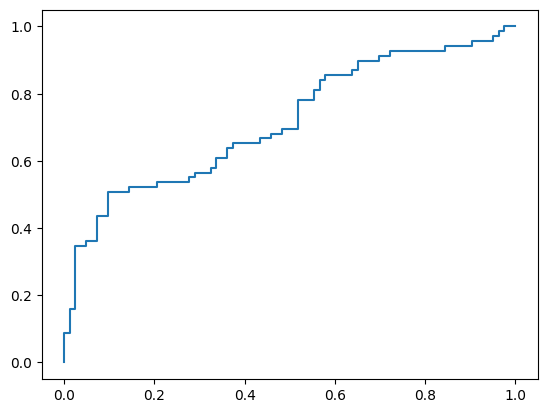

In [63]:
plt.plot(fpr, tpr)